# **1. Setting up the Environment**



---


**1. GCP Setup**


---



In [1]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

Authenticated


In [2]:
from google.auth import default
credentials, _= default()
project_id= "basic-pipeline-435315"
region= "us-central1"

In [3]:
import vertexai
from google.cloud import bigquery

vertexai.init(project=project_id, credentials=credentials, location=region)
bq_client= bigquery.Client(project=project_id, credentials=credentials)



---


**2. Kubeflow Setup**


---



In [4]:
%pip install kfp --quiet
from kfp import dsl
from kfp import compiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.6/595.6 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 12.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [69]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='kfp.*')
warnings.filterwarnings('ignore')



---


**3. Regression Setup**


---



In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.cm as cm
from scipy.stats import norm
from scipy import stats
# Create a custom viridis palette using Matplotlib's colormap
viridis = cm.get_cmap('viridis', 256)  # Use the viridis colormap
viridis_colors = viridis.colors[:256]  # Extract the colors

<ipython-input-26-e675557cc37a>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 256)  # Use the viridis colormap


In [7]:
from sklearn.impute import KNNImputer

# **2. Data Loading**

**Loading the dataset from BigQuery.**

In [60]:
query= """
       SELECT * FROM basic-pipeline-435315.House_price_train.Train
       """
job= bq_client.query(query)
train_data= job.result().to_arrow().to_pandas()

In [61]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,165,40,RM,40,5400,Pave,Pave,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,10,2007,WD,Normal,152000
1,590,40,RM,50,9100,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,Shed,600,8,2008,WD,Normal,79500
2,874,40,RL,60,12144,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,Othr,0,9,2009,WD,Normal,133000
3,1271,40,RL,NA,23595,Pave,NA,Reg,Low,AllPub,...,0,NA,NA,NA,0,4,2010,WD,Normal,260000
4,1333,20,RL,67,8877,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2009,WD,Normal,100000


In [62]:
query= """
       SELECT * FROM basic-pipeline-435315.House_price_train.Test
       """
job= bq_client.query(query)
test_data= job.result().to_arrow().to_pandas()

In [63]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1,1462,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
2,1470,20,RL,70,8400,Pave,NA,Reg,Lvl,AllPub,...,0,0,NA,MnPrv,NA,0,4,2010,WD,Normal
3,1510,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,0,NA,NA,NA,0,4,2010,WD,Normal
4,1511,20,RL,90,9900,Pave,NA,Reg,Lvl,AllPub,...,0,0,NA,NA,NA,0,4,2010,ConLD,Normal


# **3. Exploratory Data Analysis**



---


**1. Handling Null('NA') Values in Numeric Data:**


---



In [64]:
value_to_replace= 'NA'
train_data= train_data.replace(value_to_replace, np.NAN)
train_data.columns[train_data.isin(['NA']).any()]

Index([], dtype='object')

**If the missing data is huge, then it is generally useful to use a higher value for ‘k’. This is because using a higher value for ‘k’ will give more weight to the neighbors of the data point when imputing its missing value. This will help to make the imputations more generalized. Remember, more generalized doesn’t make it more accurate.**

In [65]:
# Converting the Column to numeric
train_data['LotFrontage']= pd.to_numeric(train_data['LotFrontage'], errors='coerce')
train_data['MasVnrArea']= pd.to_numeric(train_data['MasVnrArea'], errors='coerce')
train_data['GarageYrBlt']= pd.to_numeric(train_data['GarageYrBlt'], errors='coerce')

# Setting up the KNN Imputer
imputer= KNNImputer(n_neighbors=5)
df_imputed_array= imputer.fit_transform(train_data.select_dtypes(exclude= ['object']))

# Converting the resultant KNN ndarray back into pd.DataFrame
df_imputed = pd.DataFrame(df_imputed_array, columns=train_data.select_dtypes(exclude=['object']).columns)
df_final = pd.concat([df_imputed, train_data.select_dtypes(include=['object'])], axis=1)

In [66]:
df_final

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,165.0,40.0,40.0,5400.0,6.0,7.0,1926.0,2004.0,0.0,370.0,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,590.0,40.0,50.0,9100.0,5.0,6.0,1930.0,1960.0,0.0,0.0,...,Detchd,Unf,TA,TA,P,NaN,NaN,Shed,WD,Normal
2,874.0,40.0,60.0,12144.0,5.0,7.0,1949.0,1950.0,0.0,375.0,...,Attchd,Unf,TA,TA,Y,NaN,NaN,Othr,WD,Normal
3,1271.0,40.0,122.4,23595.0,7.0,6.0,1979.0,1979.0,0.0,1258.0,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,1333.0,20.0,67.0,8877.0,4.0,6.0,1938.0,1958.0,0.0,690.0,...,Detchd,Unf,Fa,Fa,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,970.0,190.0,75.0,10382.0,6.0,5.0,1958.0,1958.0,105.0,513.0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,ConLD,Normal
1456,1191.0,190.0,103.0,32463.0,4.0,4.0,1961.0,1975.0,149.0,1159.0,...,2Types,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,336.0,190.0,130.6,164660.0,5.0,6.0,1965.0,1965.0,0.0,1249.0,...,Attchd,Fin,TA,TA,Y,NaN,NaN,Shed,WD,Normal
1458,862.0,190.0,75.0,11625.0,5.0,4.0,1965.0,1965.0,0.0,841.0,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [67]:
train_data= df_final



---


**2. Analyzing the Categorical Data:**


---



**Dropping the Columns with way too many NULL Values.**

In [68]:
train_data= train_data.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   float64
 1   MSSubClass     1460 non-null   float64
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   float64
 4   OverallQual    1460 non-null   float64
 5   OverallCond    1460 non-null   float64
 6   YearBuilt      1460 non-null   float64
 7   YearRemodAdd   1460 non-null   float64
 8   MasVnrArea     1460 non-null   float64
 9   BsmtFinSF1     1460 non-null   float64
 10  BsmtFinSF2     1460 non-null   float64
 11  BsmtUnfSF      1460 non-null   float64
 12  TotalBsmtSF    1460 non-null   float64
 13  CentralAir     1460 non-null   float64
 14  1stFlrSF       1460 non-null   float64
 15  2ndFlrSF       1460 non-null   float64
 16  LowQualFinSF   1460 non-null   float64
 17  GrLivArea      1460 non-null   float64
 18  BsmtFull

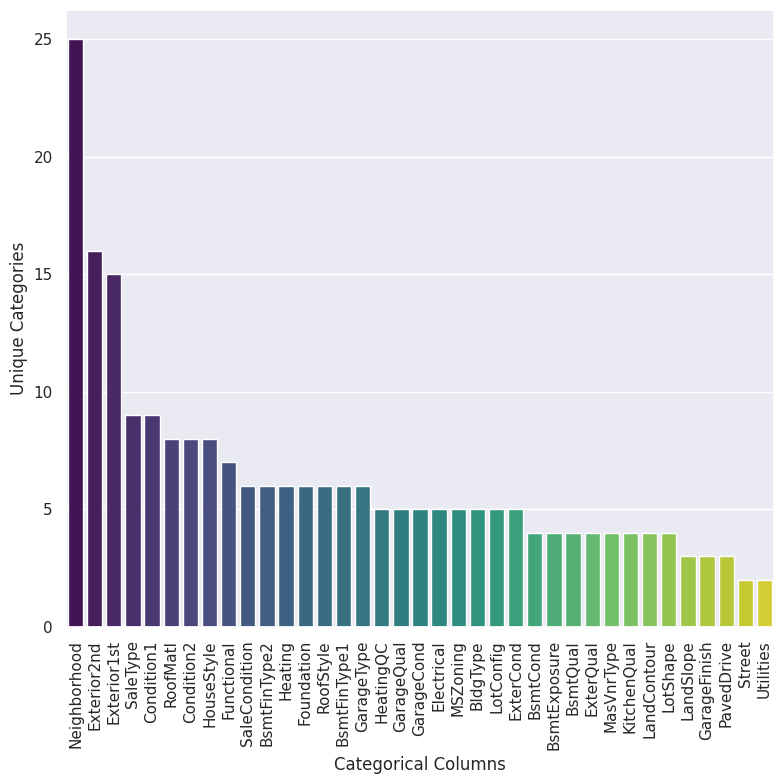

In [70]:
def barplot(df: pd.DataFrame)-> None:
  """
  Plots a barplot using seaborn.
  Args:
    df: Pandas DataFrame.
  Returns:
    None
  """
  col_list= df.select_dtypes(include= ['object']).columns
  cat=[df[col].nunique() for col in col_list]

  col_df= pd.DataFrame({'Columns': col_list, 'Unique Categories': cat})
  col_df= col_df.sort_values(by='Unique Categories', ascending=False)

  plt.figure(figsize=(8,8))
  fig= sns.barplot(x='Columns', y='Unique Categories', data=col_df, palette='viridis')
  plt.xticks(rotation=90)
  fig.set_xlabel("Categorical Columns", fontsize=12)
  fig.set_ylabel("Unique Categories", fontsize=12)
  plt.tight_layout()

  plt.show()

barplot(train_data)



---


**3. Analyzing the Target Variable.**


---




In [71]:
train_data['SalePrice'].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


<Figure size 1000x1000 with 0 Axes>

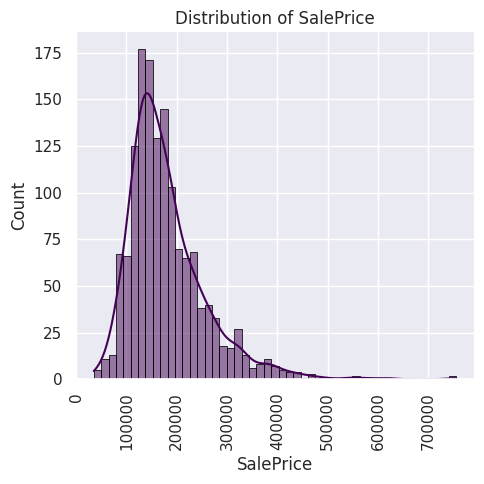

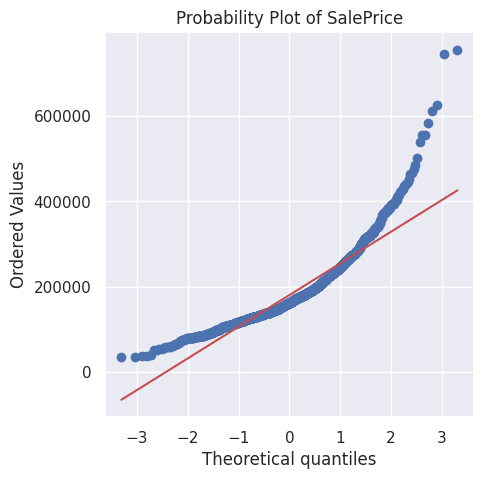

In [72]:
def distplot(df: pd.DataFrame, name: str, probplot: bool= False)-> None:
  """
  Plots a 'distplot'. Depicts the variation in the data distribution.
  Can't be plotted if there exists nan values.
  Args:
    df: Pandas DataFrame.
    name: Name of target column
  Returns:
    None
  """
  plt.figure(figsize=(10,10))
  fig= sns.displot(
      data=df[name],
      kde=True,
      color=viridis(1),
      edgecolor='black',
      )
  plt.xticks(rotation=90)
  plt.title(f"Distribution of {name}")
  plt.xlabel(f"{name}")
  plt.tight_layout()

  if probplot:
    plt.figure(figsize=(4.77,5))
    res= stats.probplot(df[name], plot=plt)
    plt.title(f"Probability Plot of {name}")

  plt.show()

distplot(train_data, 'SalePrice', probplot=True)

**As evident the Target column is postively skewed. Kurtosis is a statistical measure that describes the shape of a distribution's tails in relation to a normal distribution.**

In [73]:
print(f"Skewness: {train_data['SalePrice'].skew()}")
print(f"Kurtosis: {train_data['SalePrice'].kurtosis()}")

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


**Generating a Heatmap of correlated numerical columns in the dataframe:**

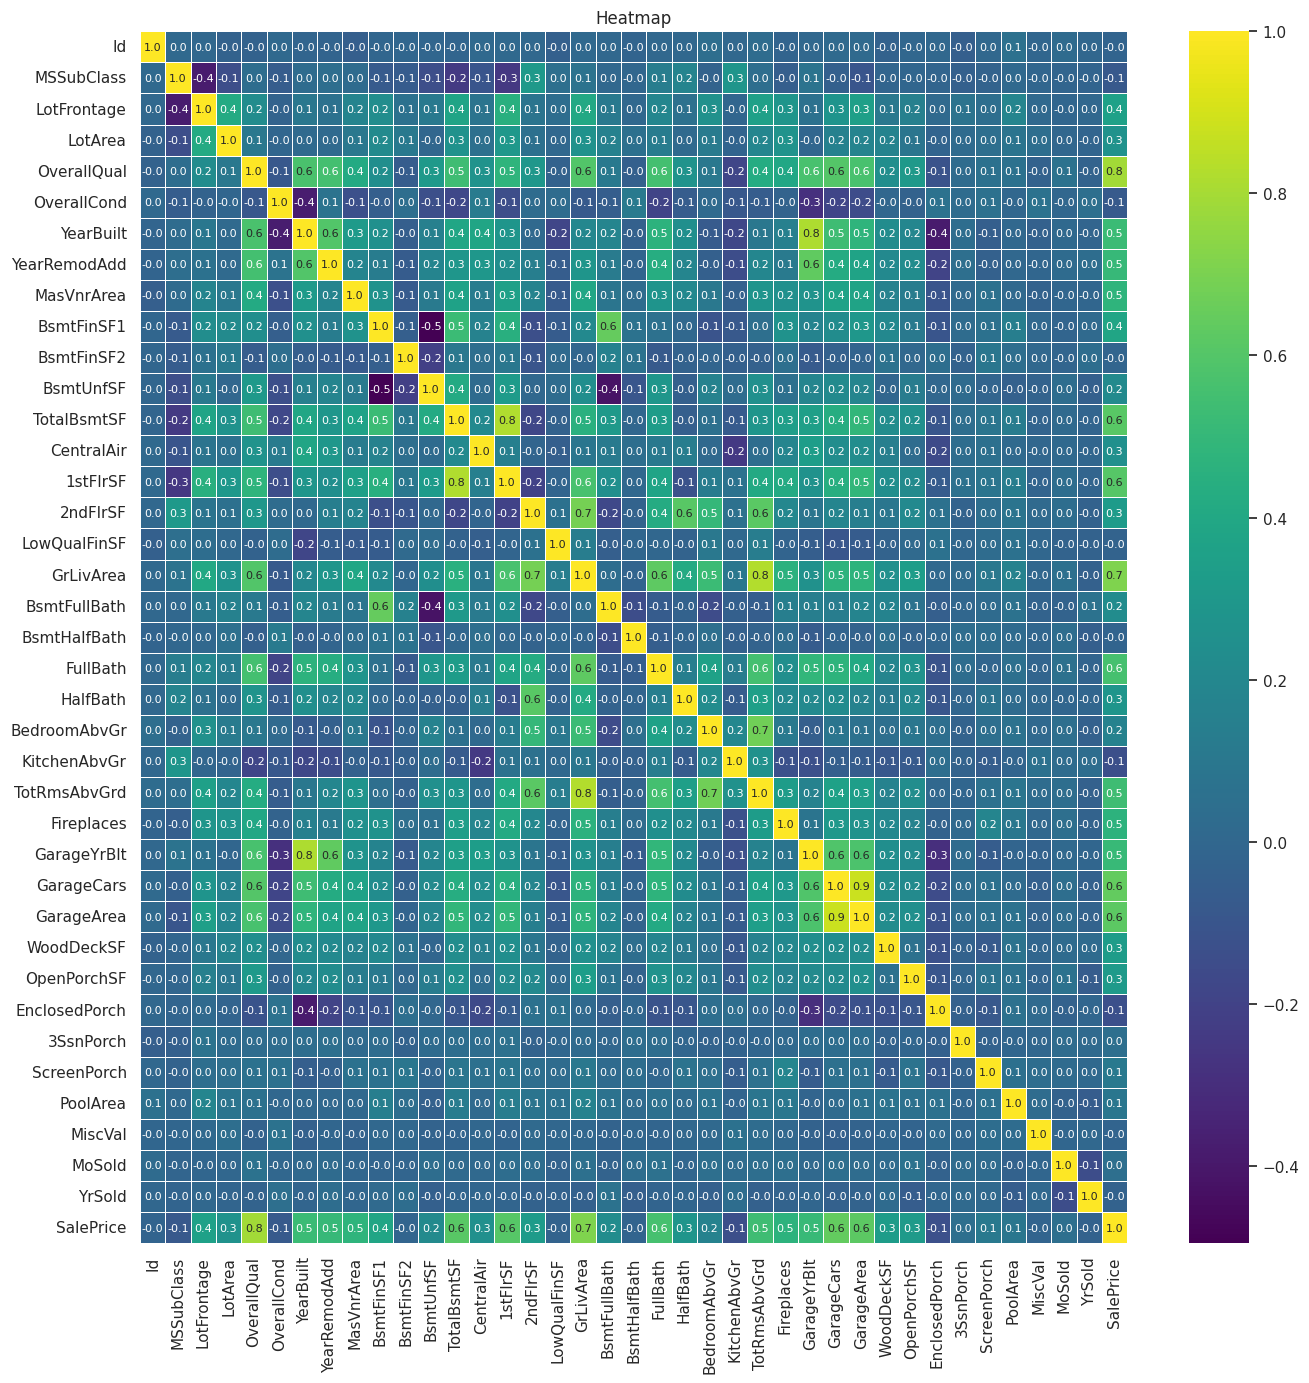

In [74]:
def heatmap(df: pd.DataFrame):
  """
  Plots a heatmap utilzing seaborn.
  Args:
    df: Correlated Pandas Dataframe.
  Returns:
    None
  """

  plt.figure(figsize=(14, 14))
  sns.heatmap(
      df,
      linewidth=0.5,
      cmap="viridis",
      cbar_kws={"orientation": "vertical"},
      annot=True,
      fmt=".1f",
      annot_kws={'size': 8},
      )
  plt.title("Heatmap")
  plt.tight_layout()

  plt.show()

numeric_df= train_data.select_dtypes(exclude = ['object'])
correlation_matrix= numeric_df.corr()
heatmap(correlation_matrix)

**Generating the heatmap for Highly Correlated Columns with SalePrice:**

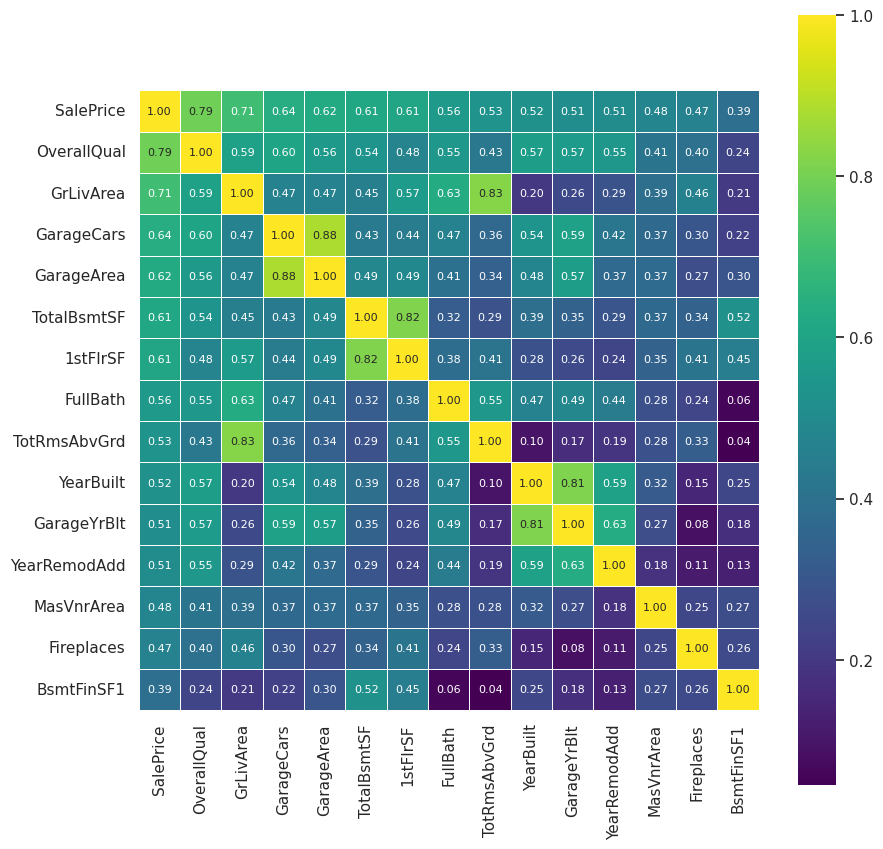

In [75]:
k= 15
cols= correlation_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm= np.corrcoef(train_data[cols].values.T)

plt.figure(figsize=(10, 10))
sns.heatmap(
    cm,
    linewidth=0.5,
    cbar=True,
    annot=True,
    square=True,
    cmap='viridis',
    fmt='.2f',
    annot_kws={'size': 8},
    yticklabels=cols.values,
    xticklabels=cols.values
    )

plt.show()

**Next, we'll plot the scatterplot matrix:**

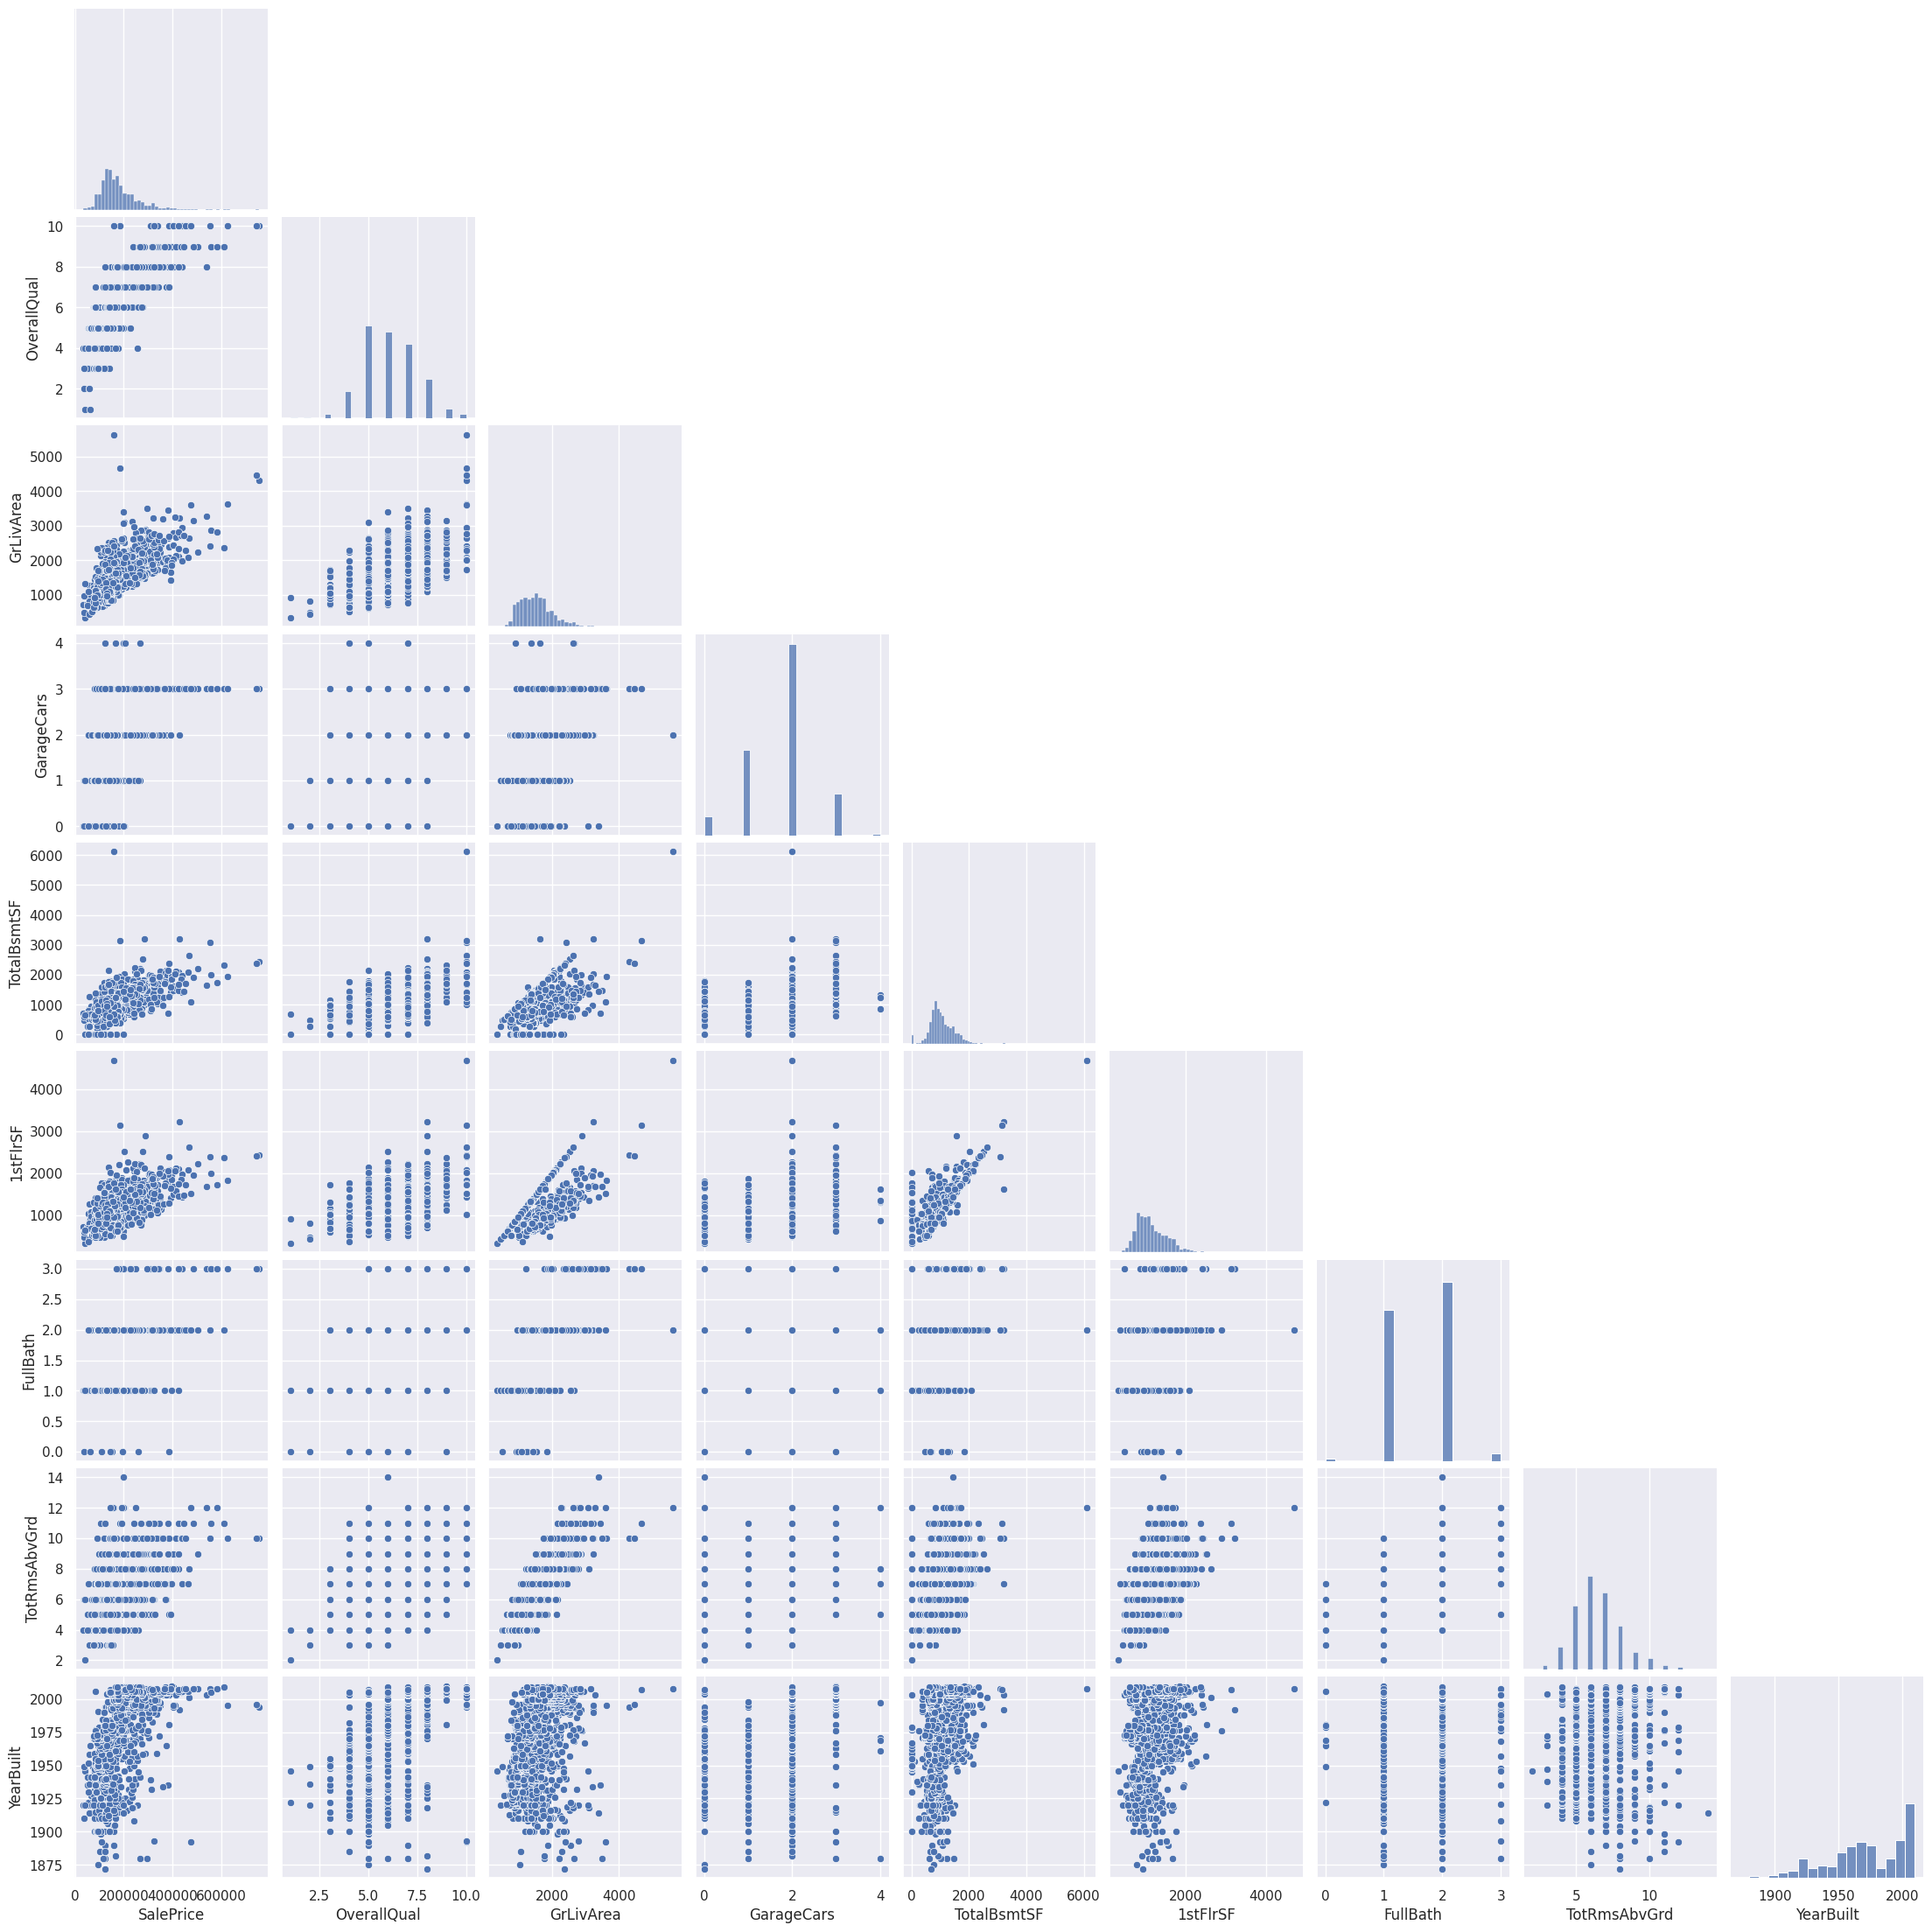

In [76]:
def scatterplot_matrix(df: pd.DataFrame, target: list)-> None:
  """
  Plots a scatterplot matrix
  Args:
    df: Pandas DataFrame.
    target: Target columns.
  Returns:
    None
  """
  sns.pairplot(df[target], corner=True)
  plt.show()

targets= ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
scatterplot_matrix(train_data, targets)



---


**4. Ensuring the correlated columns follow the normal distribution:**


---



<Figure size 1000x1000 with 0 Axes>

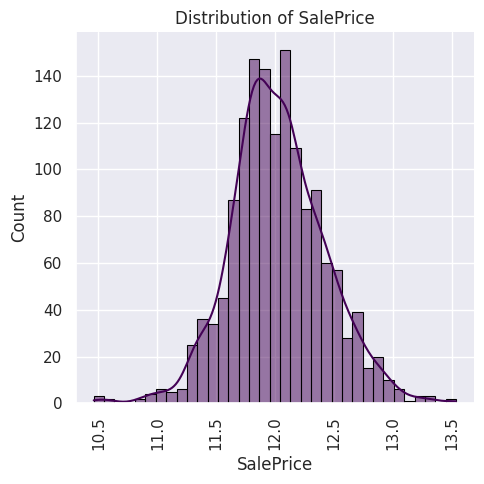

In [77]:
# Since the target column is skewed, we'll apply log transformations on it
train_data['SalePrice'] = np.log(train_data['SalePrice'])
distplot(train_data, 'SalePrice')

**That resolved it! Now, lets test for other columns:**

Skewness: 0.12133506220520401
Kurtosis: 0.8095319958036296


<Figure size 1000x1000 with 0 Axes>

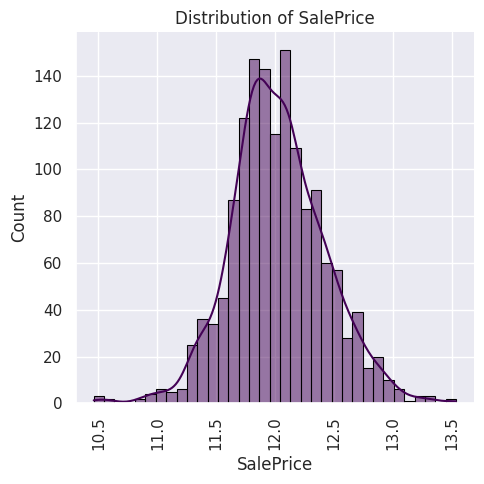

Skewness: 0.2169439277628692
Kurtosis: 0.0962927783561498


<Figure size 1000x1000 with 0 Axes>

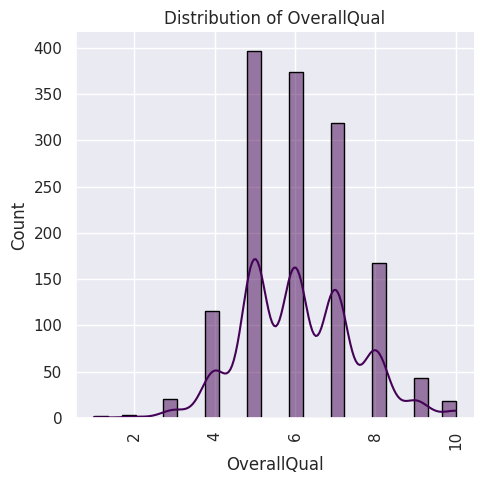

Skewness: 1.3665603560164552
Kurtosis: 4.895120580693172


<Figure size 1000x1000 with 0 Axes>

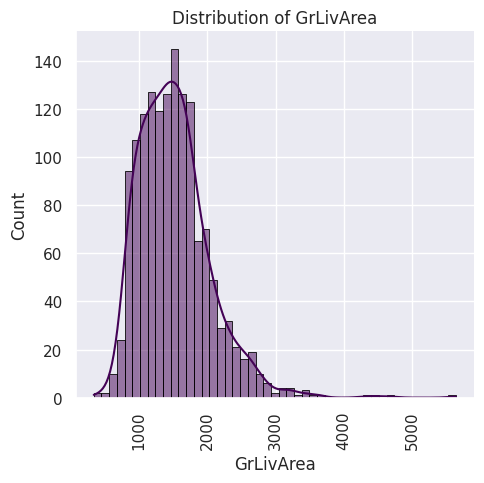

Skewness: -0.3425489297486655
Kurtosis: 0.22099776396532933


<Figure size 1000x1000 with 0 Axes>

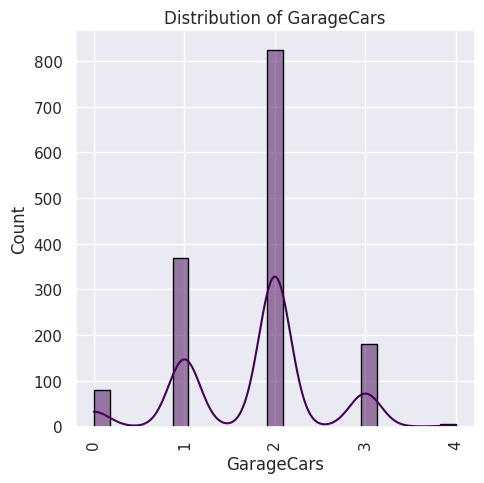

Skewness: 1.524254549062766
Kurtosis: 13.250483281984788


<Figure size 1000x1000 with 0 Axes>

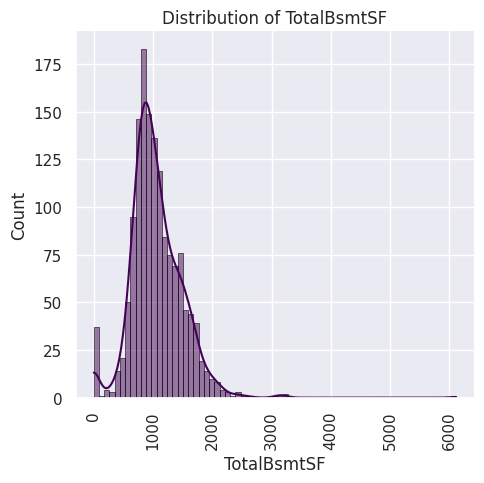

Skewness: 1.3767566220336365
Kurtosis: 5.74584148244079


<Figure size 1000x1000 with 0 Axes>

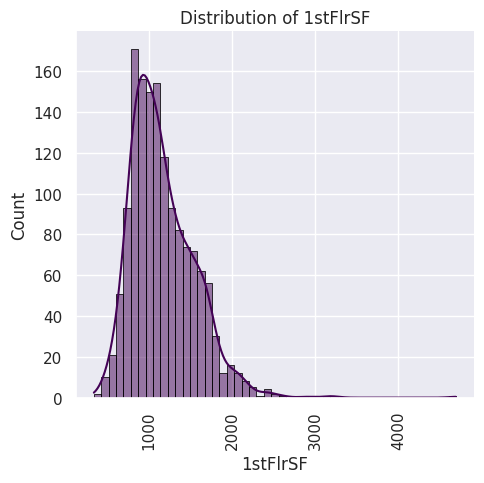

Skewness: 0.03656155840272712
Kurtosis: -0.8570428212743262


<Figure size 1000x1000 with 0 Axes>

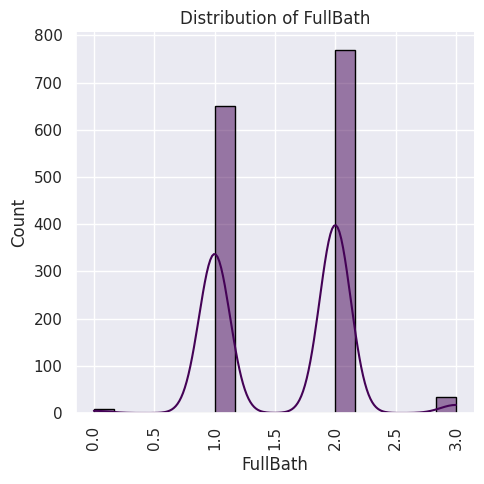

Skewness: 0.6763408364355529
Kurtosis: 0.8807615657189465


<Figure size 1000x1000 with 0 Axes>

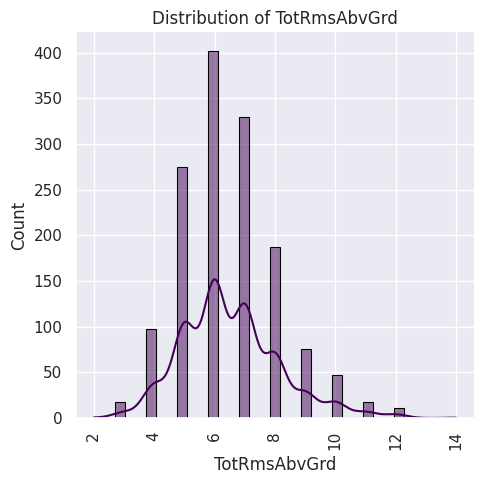

Skewness: -0.613461172488183
Kurtosis: -0.4395519415936202


<Figure size 1000x1000 with 0 Axes>

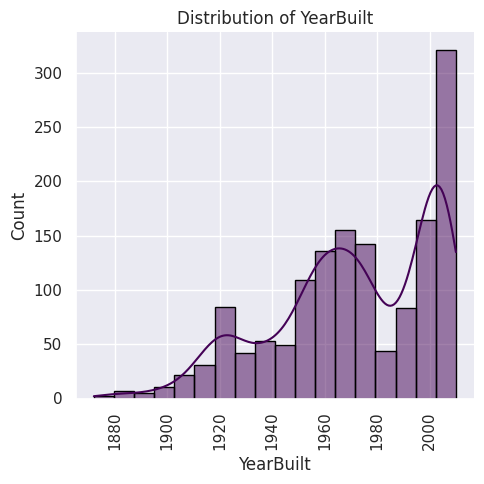

Skewness: -0.5035620027004709
Kurtosis: -1.2722451924732954


<Figure size 1000x1000 with 0 Axes>

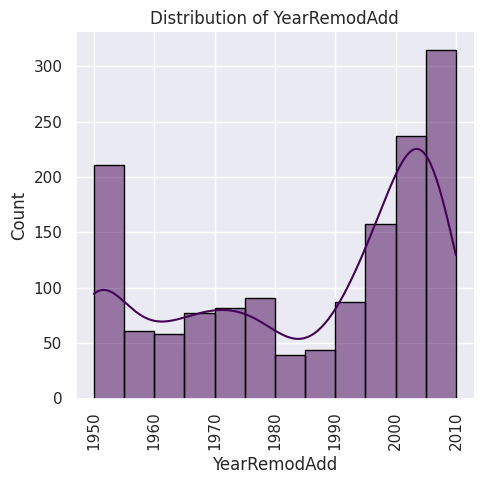

Skewness: 2.6661513924633087
Kurtosis: 10.075504856947322


<Figure size 1000x1000 with 0 Axes>

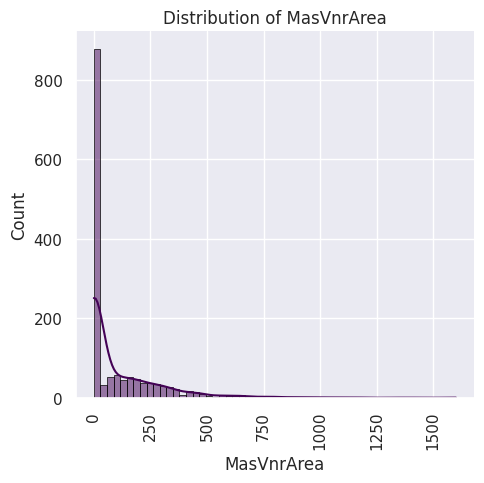

Skewness: 0.6495651830548841
Kurtosis: -0.21723720752814657


<Figure size 1000x1000 with 0 Axes>

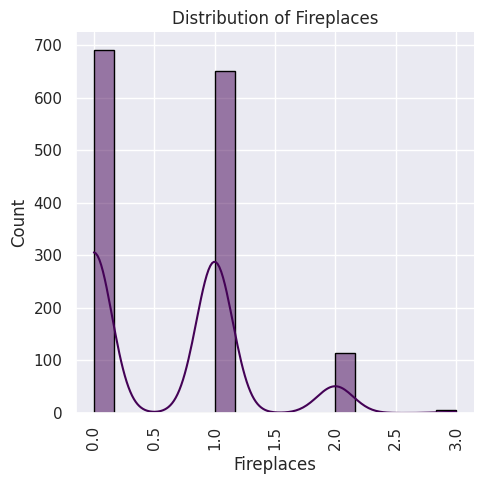

In [80]:
targets= ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces']
for i in targets:
  print(f"Skewness: {train_data[i].skew()}")
  print(f"Kurtosis: {train_data[i].kurtosis()}")
  distplot(train_data, i)

<Figure size 1000x1000 with 0 Axes>

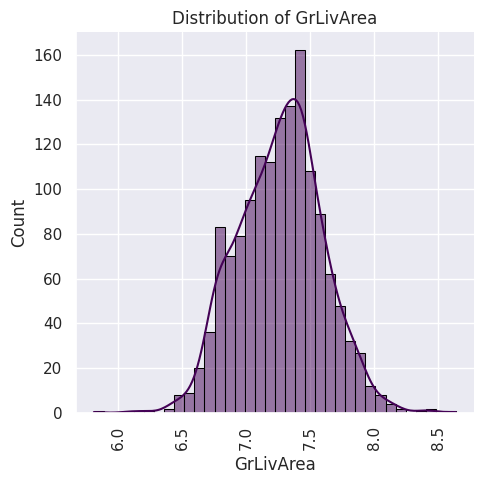

<Figure size 1000x1000 with 0 Axes>

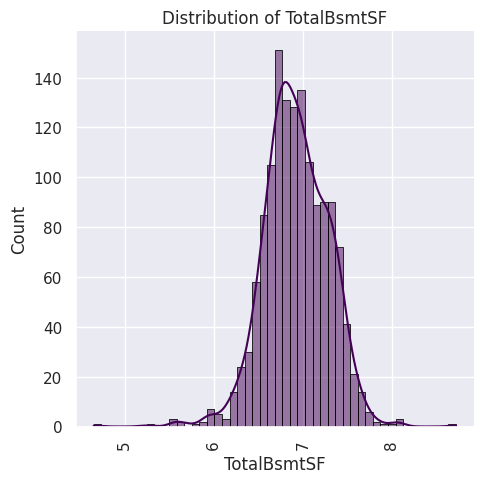

<Figure size 1000x1000 with 0 Axes>

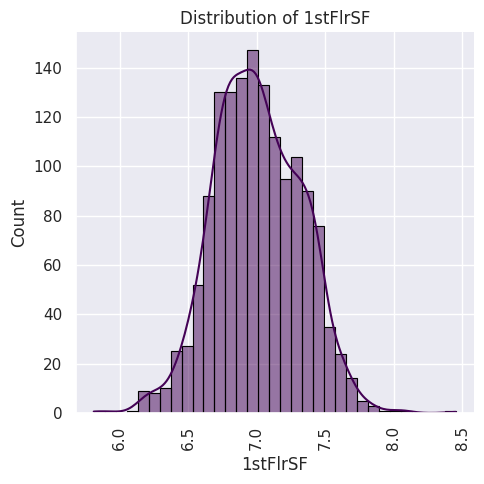

<Figure size 1000x1000 with 0 Axes>

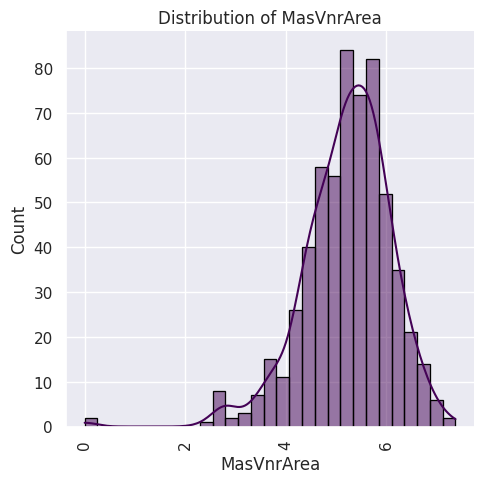

In [81]:
skewed_columns= ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'MasVnrArea']
for i in skewed_columns:
  train_data[i]= np.log(train_data[i])

for i in skewed_columns:
  distplot(train_data, i)

**With this the skewness in correlated columns to the target column have been resolved.**

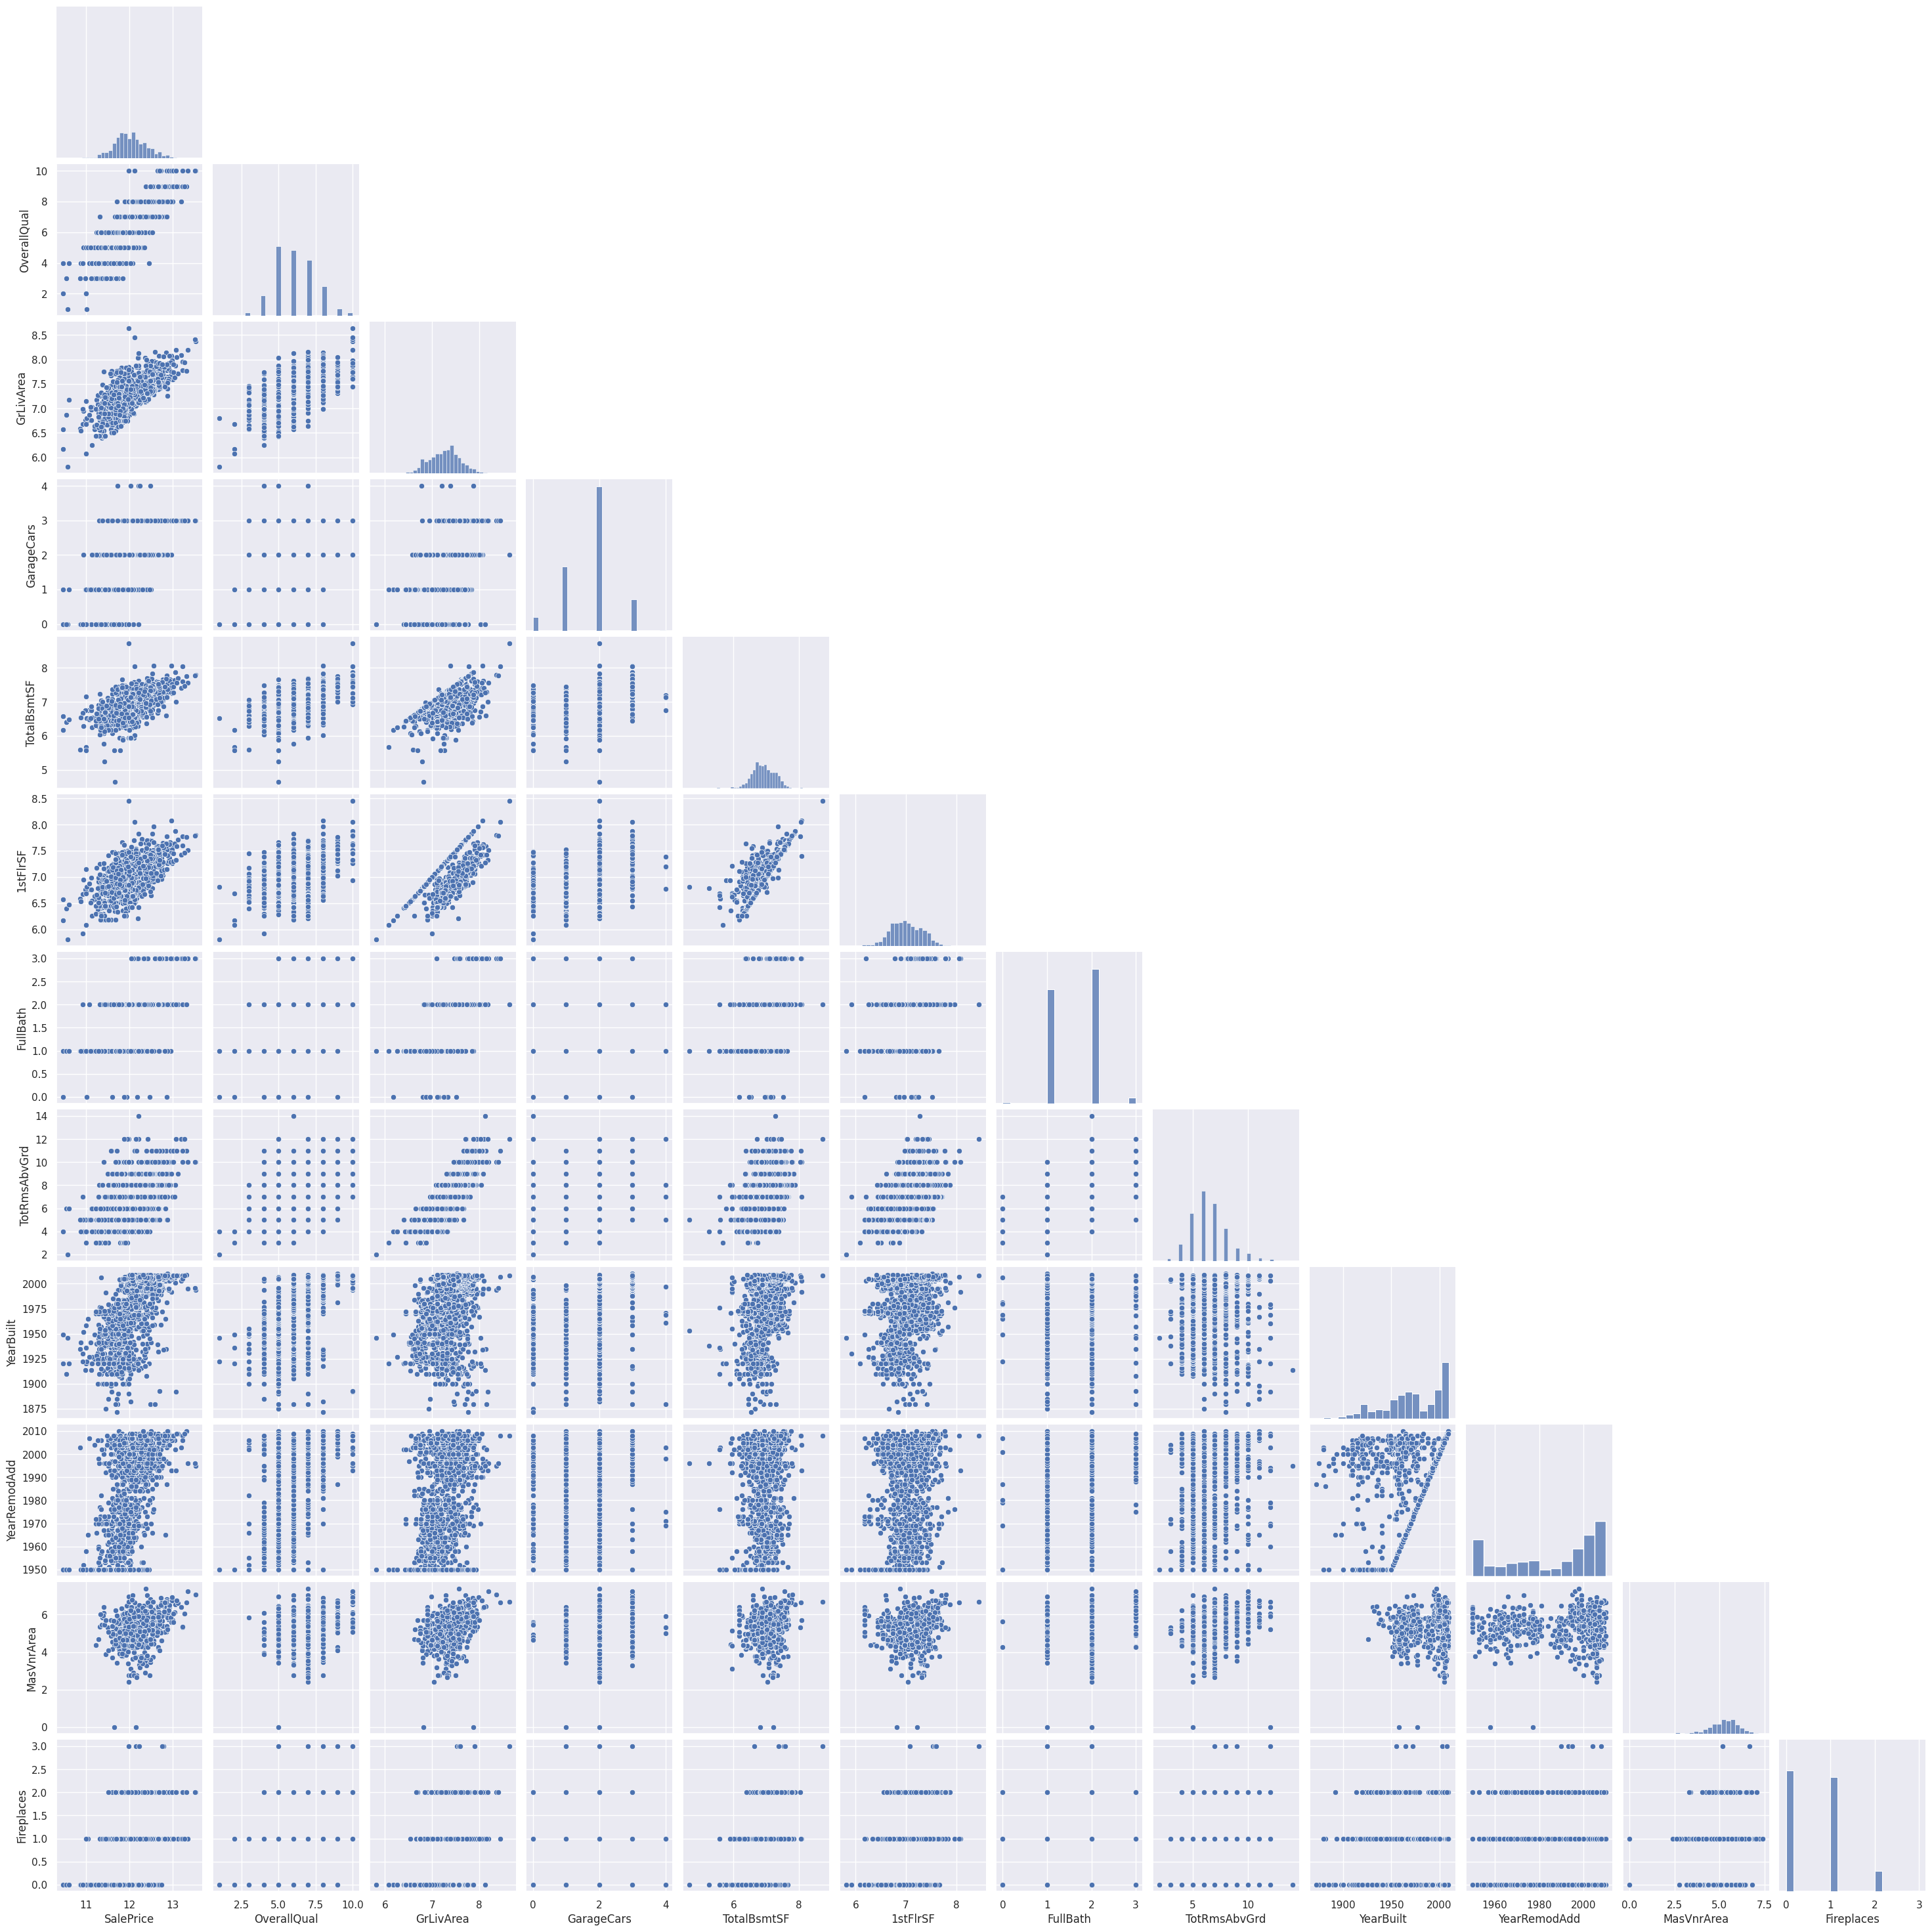

In [82]:
targets= ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces']
scatterplot_matrix(train_data, targets)